In [1]:
import pandas as pd
import numpy as np
import os

from madrigal.utils import BASE_DIR

from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DDI_PATH = BASE_DIR + 'processed_data/polypharmacy_new/DrugBank/'
VIEWS_PATH = BASE_DIR + 'processed_data/views_features_new/'

['str', 'kg', 'cv']


Before running the following code, download UniProt ID mapping file (from EBI Gene Ontology) from [this link](https://drive.google.com/file/d/1nD4CSzbfkRm5f_2WK7WMAJrOMuQ2EfRJ/view). The file was originally downloaded from [UniProt](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/) in Dec 2022. 

In [ ]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')
print(raw_drugbank_df.columns)

drug_metadata = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_ddi.pkl"))
drug_metadata["view_str"] = 1

drug_metadata = drug_metadata.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets", "enzymes", "carriers", "transporters"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])
drug_metadata["atc_codes_level_1"] = drug_metadata["atc_codes"].apply(lambda lst: list(set(atc[0] for atc in lst)) if lst == lst else [])

# confirm that "best" drug pairs don't have adverse ddi effects with another dataset
db_polypharmacy = pd.read_csv(DDI_PATH + 'drugbank_ddi_directed_final.tsv', index_col=None)[["label_indexed", "drug_index_1", "drug_index_2"]]
db_polypharmacy = pd.concat([
    db_polypharmacy,
    db_polypharmacy.rename(columns={"drug_index_1":"drug_index_2", "drug_index_2":"drug_index_1"})
], axis=0).drop_duplicates()
drugbank_ddi_classes = pd.read_pickle(BASE_DIR + "processed_data/polypharmacy_new/DrugBank/drugbank_ddi_directed_final_label_map.pkl")
normalized_rank_drugbank = np.load(BASE_DIR + "model_output/DrugBank/split_by_pairs/full_full_all_ddi_DrugBank_nash_drugs_normalized_ranks_700_5_runs_gmean_renormalized.npy", mmap_mode="r")

uniprot_id_to_name = pd.read_table(BASE_DIR + "raw_data/HUMAN_9606_idmapping.dat", header=None).rename(columns={0:"uniprot_id", 1:"source", 2:"name"})
uniprot_id_to_name = uniprot_id_to_name[uniprot_id_to_name["source"] == "Gene_Name"]  # or GeneCards or GeneWiki
uniprot_id_to_name = uniprot_id_to_name[["uniprot_id", "name"]].set_index("uniprot_id").to_dict()["name"]

organs_csv = pd.read_csv('../drugbank_ddi_organs.csv', sep='\t')

In [4]:
drug_metadata_drugbank = drug_metadata[~drug_metadata["node_id"].isna()]
drug_metadata_drugbank_with_proteins = drug_metadata_drugbank[
    (drug_metadata_drugbank["targets"].apply(len) > 0) | \
    (drug_metadata_drugbank["enzymes"].apply(len) > 0) | \
    (drug_metadata_drugbank["carriers"].apply(len) > 0) | \
    (drug_metadata_drugbank["transporters"].apply(len) > 0)
]
drug_metadata_drugbank_with_proteins.shape

(5819, 47)

In [ ]:
ddi_classes_related_transportome_excretion_decrease = [drugbank_ddi_classes.tolist().index(cl) for cl in [
    'excretion rate, decrease | serum level, increase',
    'excretion, decrease',
    'serum level of the active metabolites, increase',
    'serum level, increase',
]]
ddi_classes_related_transportome_excretion_increase = [drugbank_ddi_classes.tolist().index(cl) for cl in [
    'excretion rate, increase | serum level, decrease | efficacy, decrease',
    'excretion, increase',
    'serum level of the active metabolites, decrease',
    'serum level of the active metabolites, decrease | efficacy, decrease',
    'serum level, decrease',
]]
ddi_classes_related_transportome_all = [drugbank_ddi_classes.tolist().index(cl) for cl in [
    'absorption, decrease',
    'absorption, decrease | serum level, decrease | efficacy, decrease',
    'absorption, increase | serum level, increase | adverse effects, increase',
    
    'excretion rate, decrease | serum level, increase',
    'excretion rate, increase | serum level, decrease | efficacy, decrease',
    'excretion, decrease',
    'excretion, increase',
    
    'serum level of the active metabolites, decrease',
    'serum level of the active metabolites, decrease | efficacy, decrease',
    'serum level of the active metabolites, increase',
    'serum level, decrease',
    'serum level, increase',
]]

# Analyses

Two drugs sharing certain transporter/carrier/enzymes should have a higher tendency of certain DDI events.
- Known example in Shi et al. (2024) with ABCB1 (P-gp), ABCG2 (BCRP), ABCC2 (MRP2)
    - related to efflux, e.g. excretion, bioavailability, serum level
- General enrichment in certain DDI events according to DrugBank annotations (disregarding the identity of the shared transporters/carrier/enzymes)
- For each transporter (focusing on those said to clinically cause DDIs in Galetin et al. (2024)), do drug pairs sharing it tend to be enriched in certain DDI events (compared to random drug pairs) that are either:
    - related to intake/efflux
    - specific to certain organs

### Shi et al. (2024) examples

In [8]:
drug_metadata[drug_metadata["node_name"].isin({"Doxycycline", "Warfarin", "Digoxin", "Levetiracetam", "Tacrolimus"})][["node_name", "node_id", "indication", "moa", "indication_drugbank", "targets", "enzymes", "carriers", "transporters"]]

,node_name,node_id,indication,moa,indication_drugbank,targets,enzymes,carriers,transporters
186,Doxycycline,DB00254,periodontitis,Protein synthesis is essential for survival an...,Doxycycline is indicated for the treatment of ...,[],[P08684],[P02768],"[Q4U2R8, Q2M3G0]"
275,Digoxin,DB00390,"congestive heart failure, atrial fibrillation ...","Digoxin exerts hemodynamic, electrophysiologic...",Digoxin is indicated in the following conditio...,[P05023],[P05108],[],"[P08183, Q6ZQN7, O95342, P46721, Q86UW1, Q86UW..."
459,Warfarin,DB00682,"deep vein thrombosis (DVT), pulmonary embolism...",Warfarin is a [vitamin K] antagonist which act...,"**Indicated** for:[label,L6616]\r\n\r\n1) Prop...","[Q9BQB6, O75469]","[P11712, P05177, P33261, P08684, P10632, P33260]","[P02768, P02763]",[]
582,Tacrolimus,DB00864,organ rejection,The mechanism of action of tacrolimus in atopi...,Immediate-release formulations of tacrolimus a...,[P62942],"[P08684, P20815]","[P02768, P02763]","[P08183, Q8WWZ7, Q9Y6L6]"
796,Levetiracetam,DB01202,seizures,The exact mechanism through which levetiraceta...,Levetiracetam is indicated as an adjunctive th...,"[Q00975, Q7L0J3]",[],[],[P08183]


In [11]:
drug_metadata[(~drug_metadata["node_name"].isna()) & drug_metadata["node_name"].str.contains("iracetam")][["node_name", "canonical_smiles"]]

,node_name,canonical_smiles
796,Levetiracetam,CC[C@@H](C(N)=O)N1CCCC1=O
1307,Piracetam,NC(=O)CN1CCCC1=O
1753,Aniracetam,COc1ccc(C(=O)N2CCCC2=O)cc1
2876,Etiracetam,CCC(C(N)=O)N1CCCC1=O
2996,Nefiracetam,Cc1cccc(C)c1NC(=O)CN1CCCC1=O
3162,Oxiracetam,NC(=O)CN1C[C@H](O)CC1=O
6964,Pramiracetam,CC(C)N(CCNC(=O)CN1CCCC1=O)C(C)C
9977,Dimiracetam,O=C1CN2C(=O)CCC2N1


In [ ]:
drugs = {
    "Doxycycline": 186,

    "Digoxin": [275],
    "Warfarin": [459], 
    "Tacrolimus": [582],
    "Levetiracetam": [796],
    "Piracetam": [1307],
}

In [24]:
db_polypharmacy[
    (db_polypharmacy["drug_index_1"] == drugs["Doxycycline"]) & \
    db_polypharmacy["drug_index_2"].isin(drugs["Digoxin"]+drugs["Warfarin"]+drugs["Tacrolimus"]+drugs["Levetiracetam"]+drugs["Piracetam"])
]

,label_indexed,drug_index_1,drug_index_2
89157,47,186,1307
89261,47,186,275
89355,47,186,582
89414,28,186,459


In [27]:
normalized_rank_drugbank[ddi_classes_related_transportome_excretion_decrease, drugs["Doxycycline"], :][:, drugs["Digoxin"] + drugs["Warfarin"] + drugs["Tacrolimus"] + drugs["Levetiracetam"] + drugs["Piracetam"]].max(0)

array([0.9979969 , 0.998859  , 0.99845326, 0.82120806, 0.9997276 ],
      dtype=float32)

In [43]:
for drug_name, drug_ind in drugs.items():
    if drug_name == "Doxycycline":
        continue
    drug_ind = drug_ind[0]
    print(drug_name)
    print((np.where(np.sort(normalized_rank_drugbank[:, :, drug_ind][ddi_classes_related_transportome_excretion_decrease, :].max(0)) == normalized_rank_drugbank[ddi_classes_related_transportome_excretion_decrease, drugs["Doxycycline"], drug_ind].max())[0] - 1)[0] / (normalized_rank_drugbank.shape[1] - 1))
    print((np.where(np.sort(normalized_rank_drugbank[:, :, drugs["Doxycycline"]][ddi_classes_related_transportome_excretion_decrease, :].max(0)) == normalized_rank_drugbank[ddi_classes_related_transportome_excretion_decrease, drugs["Doxycycline"], drug_ind].max())[0] - 1)[0] / (normalized_rank_drugbank.shape[1] - 1))

Digoxin
0.9209029812166121
0.9352920902981217
Warfarin
0.9878511114940548
0.9606238152679648
Tacrolimus
0.9453730828881612
0.9489057384111667
Levetiracetam
0.8611063243150094
0.37730484232293643
Piracetam
0.9705324831983457
0.9914699293468895


### General correlations

In [ ]:
ddi_classes_related_proteins_all_related = {}
ddi_classes_related_proteins_all_related["transporters"] = ddi_classes_related_transportome_all
ddi_classes_related_proteins_all_related["enzymes"] = [drugbank_ddi_classes.tolist().index(cl) for cl in [
    'bioavailability, decrease',
    'bioavailability, increase',
    'metabolism, decrease',
    'metabolism, increase',
    'serum level of the active metabolites, decrease',
    'serum level of the active metabolites, decrease | efficacy, decrease',
    'serum level of the active metabolites, increase',
]]
ddi_classes_related_proteins_all_related["carriers"] = [drugbank_ddi_classes.tolist().index(cl) for cl in [
    'protein binding, decrease',
    'serum level, decrease',
    'serum level, increase',
]]
ddi_classes_related_proteins_all_related["targets"] = [drugbank_ddi_classes.tolist().index(cl) for cl in [
    'excretion rate, decrease | serum level, increase',
    'excretion rate, increase | serum level, decrease | efficacy, decrease',
    'excretion, decrease',
    'excretion, increase',
    'serum level of the active metabolites, decrease',
    'serum level of the active metabolites, decrease | efficacy, decrease',
    'serum level of the active metabolites, increase',
    'serum level, decrease',
    'serum level, increase',
]]

In [47]:
drug_metadata_drugbank_with_proteins[drug_metadata_drugbank_with_proteins["targets"].apply(len) > 0]["targets"]

0        [P41439, P14207, P15328]
1                        [O00764]
2                        [P11473]
3                        [P30556]
4                        [P20711]
                   ...           
11309                    [P20292]
11311    [P24046, P28476, A8MPY1]
11312                    [P23458]
11332                    [P07288]
11374                    [P35869]
Name: targets, Length: 5265, dtype: object

In [ ]:
for protein_type in ["targets", "transporters", "carriers", "enzymes"]:
    drug_proteins = drug_metadata_drugbank_with_proteins[drug_metadata_drugbank_with_proteins[protein_type].apply(len) > 0][protein_type]

    drug_proteins_share_binary_mat = []
    for proteins_1 in drug_proteins:
        proteins_share_bin_profile = []
        for proteins_2 in drug_proteins:
            if len(set(proteins_1) & set(proteins_2)) > 0:
                proteins_share_bin_profile.append(1)
            else:
                proteins_share_bin_profile.append(0)
        drug_proteins_share_binary_mat.append(proteins_share_bin_profile)

    drug_proteins_share_binary_mat = pd.DataFrame(drug_proteins_share_binary_mat, index=drug_proteins.index, columns=drug_proteins.index)
    drug_proteins_share_binary_long = pd.melt(drug_proteins_share_binary_mat.reset_index().rename(columns={"index":"drug_index_1"}), id_vars=["drug_index_1"], var_name="drug_index_2", value_name="share_protein")
    drug_proteins_share_binary_long = drug_proteins_share_binary_long[drug_proteins_share_binary_long["drug_index_1"] > drug_proteins_share_binary_long["drug_index_2"]]

    drug_proteins_share_true_long = drug_proteins_share_binary_long[drug_proteins_share_binary_long["share_protein"]==1]
    drug_proteins_share_false_long = drug_proteins_share_binary_long[drug_proteins_share_binary_long["share_protein"]==0]

    # memmap is very bad at advanced indexing, so we need to index every time only single element in some dimensions
    normalized_rank_drug_with_proteins = []
    for drug_ind in drug_proteins.index.values:
        normalized_rank_drug_with_proteins.append(normalized_rank_drugbank[ddi_classes_related_proteins_all_related[protein_type], drug_ind, :][:, drug_proteins.index.values])
    normalized_rank_drug_with_proteins = np.stack(normalized_rank_drug_with_proteins, axis=1)
    normalized_rank_drug_with_proteins_max = pd.DataFrame(normalized_rank_drug_with_proteins.max(0), index=drug_proteins.index, columns=drug_proteins.index)

    drug_ind_to_new_id = pd.Series(normalized_rank_drug_with_proteins_max.columns).reset_index().set_index(0)["index"]
    normalized_rank_drug_with_proteins_max_share_false = normalized_rank_drug_with_proteins_max.values[
        drug_ind_to_new_id[drug_proteins_share_false_long["drug_index_1"].values],
        drug_ind_to_new_id[drug_proteins_share_false_long["drug_index_2"].values]
    ]
    normalized_rank_drug_with_proteins_max_share_true = normalized_rank_drug_with_proteins_max.values[
        drug_ind_to_new_id[drug_proteins_share_true_long["drug_index_1"].values],
        drug_ind_to_new_id[drug_proteins_share_true_long["drug_index_2"].values]
    ]

    plt.figure(figsize=(4, 6), dpi=300)
    sns.set(context="paper", style="ticks", font_scale=2)
    sns.boxplot(
        pd.DataFrame({
            "max_normalized_rank": normalized_rank_drug_with_proteins_max_share_false.tolist() + normalized_rank_drug_with_proteins_max_share_true.tolist(),
            f"share_{protein_type}": ["No"] * normalized_rank_drug_with_proteins_max_share_false.shape[0] + \
            ["Yes"] * normalized_rank_drug_with_proteins_max_share_true.shape[0],
        }), x=f"share_{protein_type}", 
        y="max_normalized_rank", 
        color="dimgray", showfliers=False, fill=False,
    )
    sns.despine()
    plt.ylabel("Max normalized rank")  # of\n{protein_type}-related DDI events
    plt.xlabel(f"Overlap in {protein_type}")
    plt.title(protein_type.capitalize())  # -mediated DDIs
    plt.savefig(f"../figs/fig2_protein_mechanism_{protein_type}_mediated_ddi_enrichment.svg", format="svg", dpi=300)
    plt.show()

    print(
        mannwhitneyu(normalized_rank_drug_with_proteins_max_share_false, normalized_rank_drug_with_proteins_max_share_true)
    )

: 

### Investigating specific transporters according to Galetin et al. (2024)

Also check:

> The drug interactions of olaparib, particularly with CYP3A inhibitors or inducers, demand careful consideration. Avoiding these interactions is preferred, but dose adjustments according to clinical guidelines are required if necessary [11, 12]. Similarly, when prescribing talazoparib, it is recommended to stop any P-glycoprotein inhibitors where possible. Where this is not feasible, talazoparib dose reduction according to guidelines is recommended [14, 30]. 




Transporters

In [8]:
transporters_of_interest_organs = {
    "P08183":["Enterocytes", "Hepatocytes", "Renal", "BBB", "Placenta"],  # ABCB1 (P-gp)
    "Q9UNQ0":["Enterocytes", "Hepatocytes", "BBB", "Placenta"],  # ABCG2 (BCRP)
    "Q9Y6L6":["Hepatocytes",],  # SLCO1B1 (OATP1B1)
    "Q9NPD5":["Hepatocytes",],  # SLCO1B3 (OATP1B3)
    "O15244":["Renal",],  # SLC22A2 (OCT2)
    "Q4U2R8":["Renal",],  # SLC22A6 (OAT1)
    "Q8TCC7":["Renal",],  # SLC22A8 (OAT3)
    "Q96FL8":["Renal",],  # SLC47A1 (MATE1)
    "Q86VL8":["Renal",],  # SLC47A2 (MATE2K)
    # "O95342":["Enterocytes", "Hepatocytes", "Renal", "BBB", "Placenta"],  # ABCB11 (BSEP)
}
transporter_uniprot_to_protein_name = {
    "P08183":"P-gp",
    "Q9UNQ0":"BCRP",
    "Q9Y6L6":"OATP1B1",
    "Q9NPD5":"OATP1B3",
    "O15244":"OCT2",
    "Q4U2R8":"OAT1",
    "Q8TCC7":"OAT3",
    "Q96FL8":"MATE1",
    "Q86VL8":"MATE2K",
}
assert set(list(transporters_of_interest_organs.keys())) - set(sum(drug_metadata_drugbank_with_proteins["transporters"].values.tolist(), start=[])) == set()

In [60]:
all_transporter_ddi_scores_grouped_sorted_by_median = {}
organs_csv_neutralized = organs_csv.copy()
organs_csv_neutralized["ddi_class"] = organs_csv_neutralized["ddi_class"].apply(lambda x: x.replace(", increase", "").replace(", decrease", "").replace(" | ", ", ").replace("Change", "change"))
organs_csv_neutralized_unique = organs_csv_neutralized.drop_duplicates(subset=["ddi_class"]).reset_index(drop=True)
    
for transporter in transporters_of_interest_organs.keys():
    drugs_with_transporter = drug_metadata_drugbank_with_proteins[drug_metadata_drugbank_with_proteins["transporters"].apply(lambda st: transporter in st)].index.values
    normalized_ranks_drugs_with_transporter = normalized_rank_drugbank[:, drugs_with_transporter, :][:, :, drugs_with_transporter]
    tril_indices = np.tril_indices(normalized_ranks_drugs_with_transporter.shape[1], k=-1)
    
    normalized_ranks_drugs_with_transporter_grouped = np.empty((
        organs_csv_neutralized_unique.shape[0], 
        normalized_ranks_drugs_with_transporter.shape[1],
        normalized_ranks_drugs_with_transporter.shape[2],
    ))

    for ind, ddi_class in enumerate(organs_csv_neutralized_unique["ddi_class"].values):
        normalized_ranks_drugs_with_transporter_grouped[ind, :, :] = normalized_ranks_drugs_with_transporter[organs_csv_neutralized["ddi_class"].values == ddi_class, :, :].max(axis=0)
    
    transporter_ddi_scores_grouped_sorted_by_median = np.median(normalized_ranks_drugs_with_transporter_grouped[:, tril_indices[0], tril_indices[1]], axis=1)
    temp = organs_csv_neutralized_unique.iloc[np.argsort(transporter_ddi_scores_grouped_sorted_by_median)[::-1]]
    temp["normalized_rank"] = np.sort(transporter_ddi_scores_grouped_sorted_by_median)[::-1]
    all_transporter_ddi_scores_grouped_sorted_by_median[transporter] = temp

highest_ddi_phenos = list(set(sum([df.index[:10].values.tolist() for df in all_transporter_ddi_scores_grouped_sorted_by_median.values()], start=[])))

/tmp/ipykernel_20193/3703077842.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(transporter_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/3703077842.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(transporter_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/3703077842.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
all_transporter_ddi_scores_grouped_highest_ddi_phenos = {}

for transporter in transporters_of_interest_organs:
    all_transporter_ddi_scores_grouped_highest_ddi_phenos[transporter] = \
    all_transporter_ddi_scores_grouped_sorted_by_median[transporter]["normalized_rank"].loc[highest_ddi_phenos]
    all_transporter_ddi_scores_grouped_highest_ddi_phenos[transporter+"_rank"] = \
    np.argsort(all_transporter_ddi_scores_grouped_sorted_by_median[transporter]["normalized_rank"].index.values)[highest_ddi_phenos] + 1

all_transporter_ddi_scores_grouped_highest_ddi_phenos = pd.DataFrame.from_dict(all_transporter_ddi_scores_grouped_highest_ddi_phenos)
all_transporter_ddi_scores_grouped_highest_ddi_phenos["ddi_index"] = highest_ddi_phenos
all_transporter_ddi_scores_grouped_highest_ddi_phenos["ddi_phenotype"] = organs_csv_neutralized_unique.loc[highest_ddi_phenos, "ddi_class"].values

all_transporter_ddi_scores_grouped_highest_ddi_phenos["temp"] = all_transporter_ddi_scores_grouped_highest_ddi_phenos[
    [col for col in all_transporter_ddi_scores_grouped_highest_ddi_phenos.columns if col not in {"ddi_index", "ddi_phenotype", "temp"} and not col.endswith("_rank")]
].mean(1)
all_transporter_ddi_scores_grouped_highest_ddi_phenos = (
    all_transporter_ddi_scores_grouped_highest_ddi_phenos.
    sort_values("temp", ascending=False).
    drop(columns=["ddi_index", "temp"])
).set_index("ddi_phenotype")
all_transporter_ddi_scores_grouped_highest_ddi_phenos.columns = all_transporter_ddi_scores_grouped_highest_ddi_phenos.columns.map(lambda x: transporter_uniprot_to_protein_name[x] if x in transporter_uniprot_to_protein_name.keys() else x)

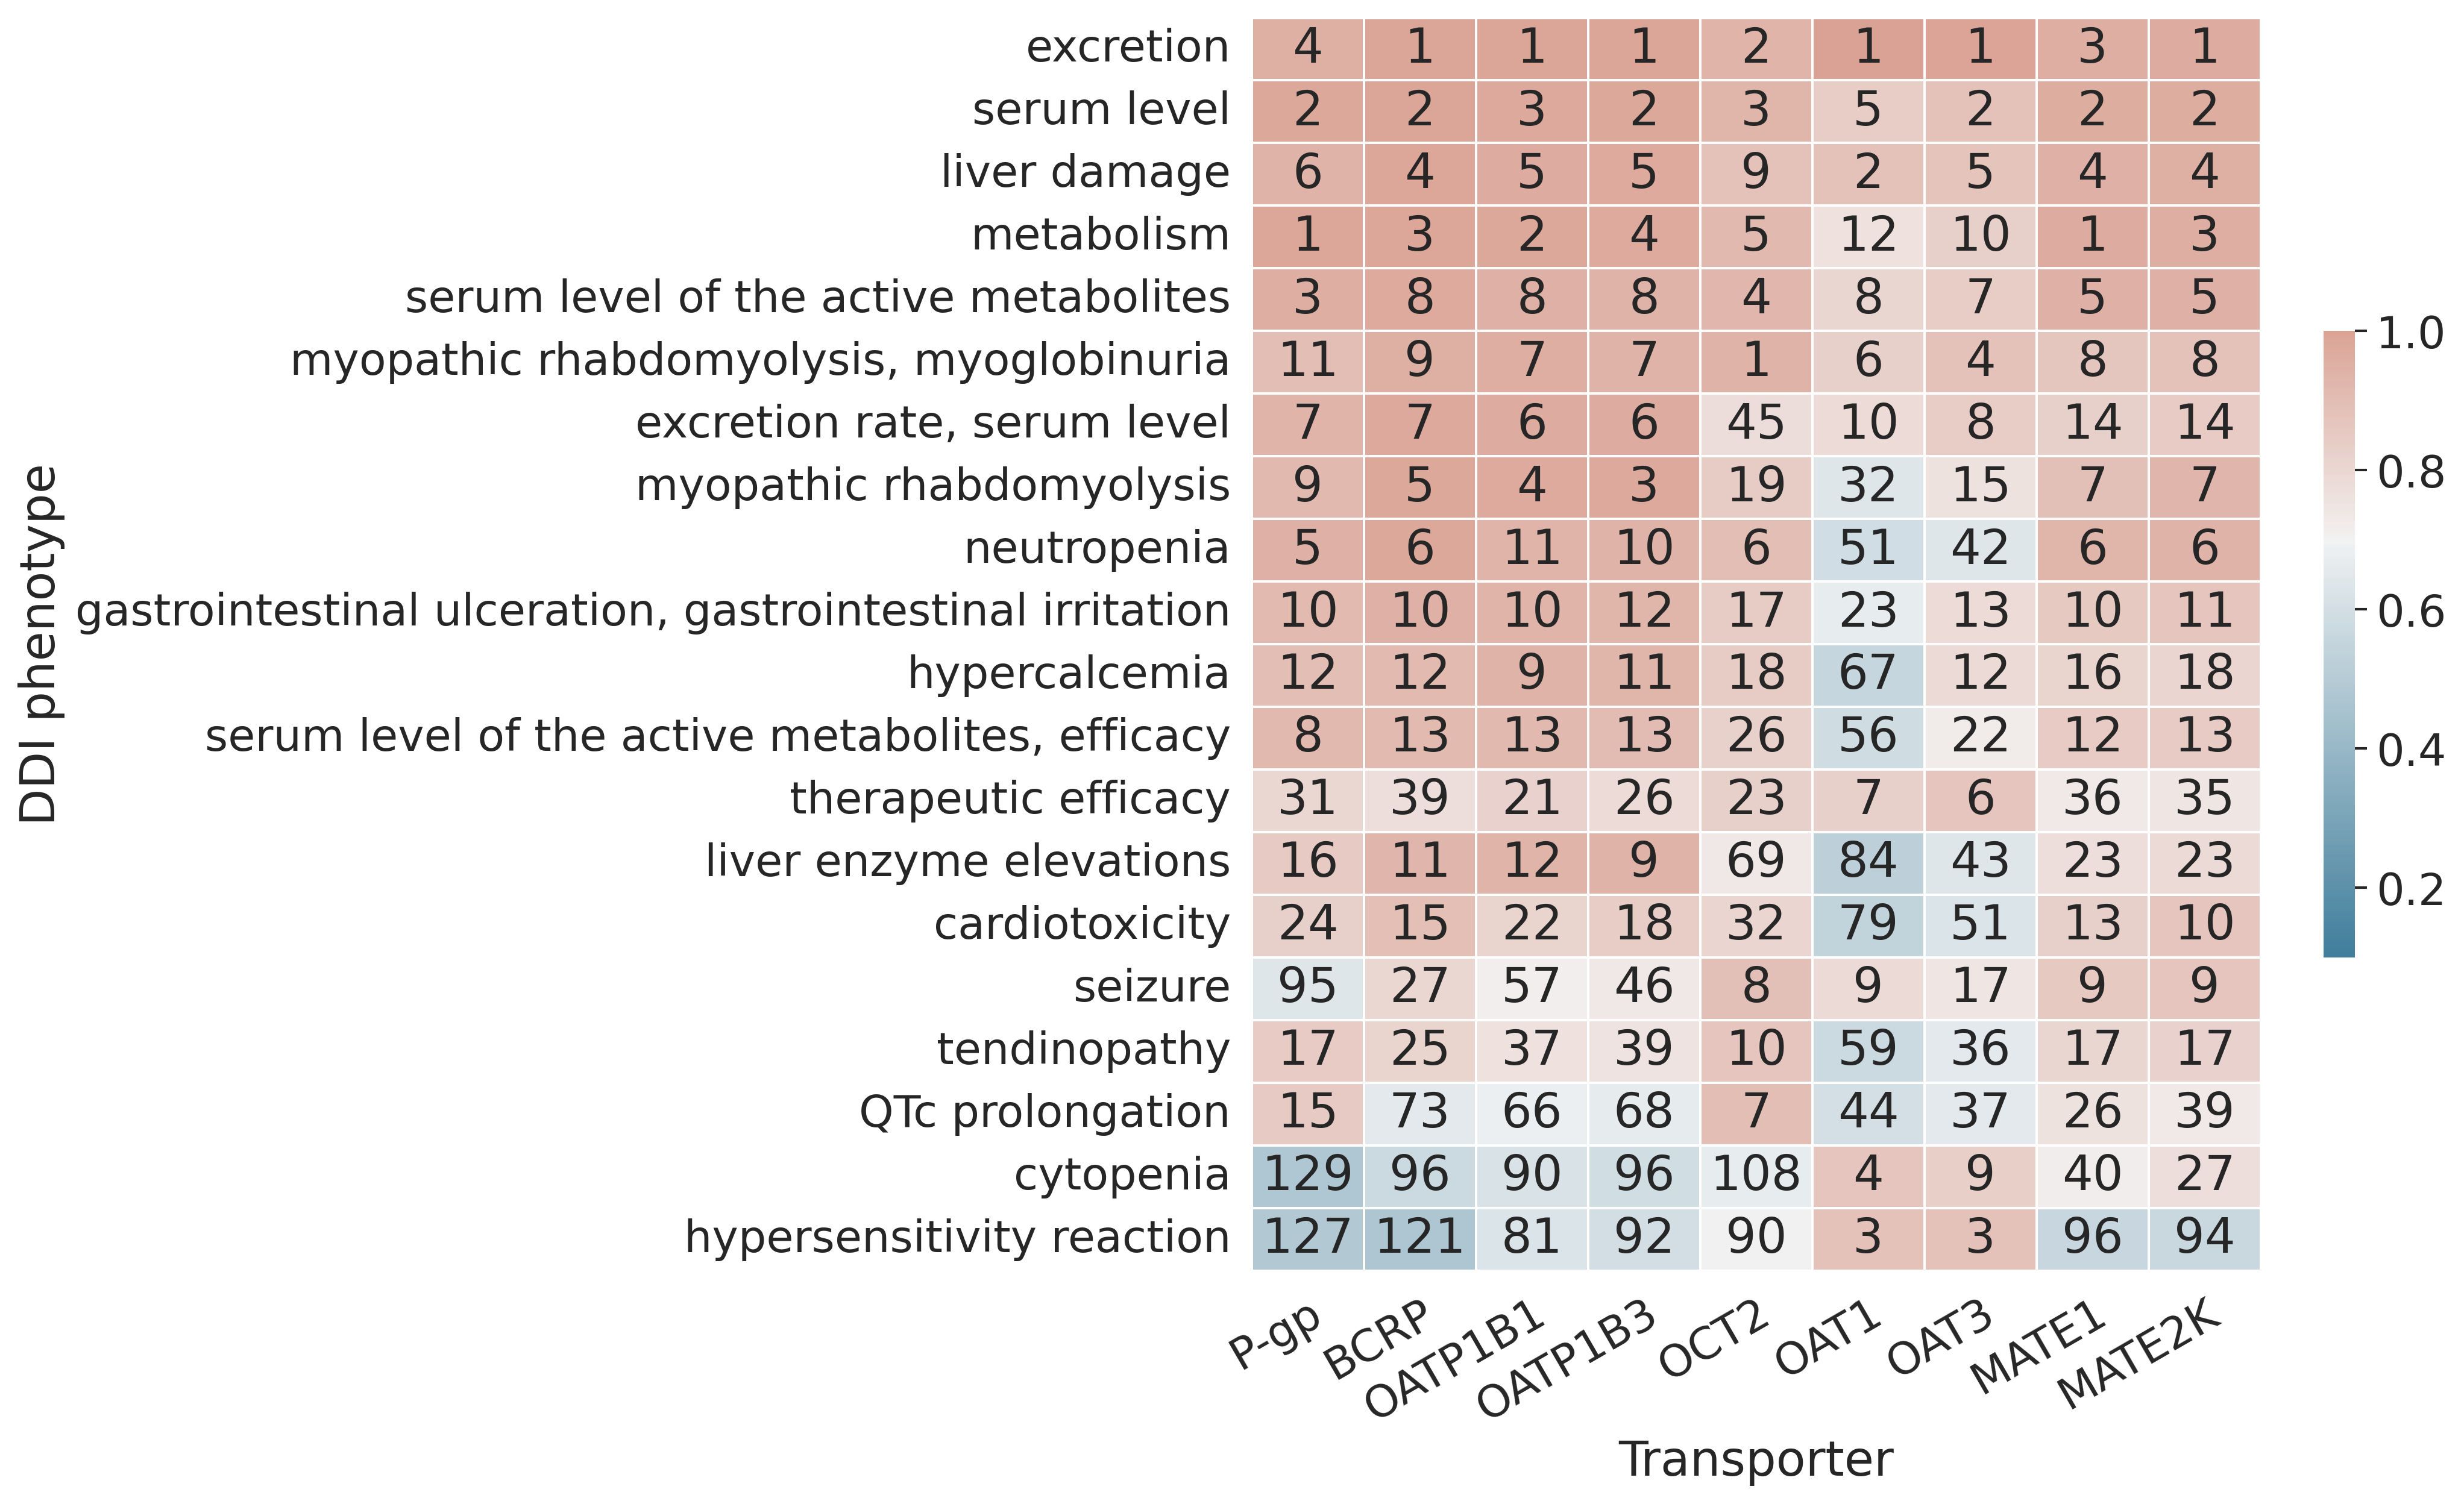

In [ ]:
f, ax = plt.subplots(figsize=(9, 9), dpi=300)
sns.set(context="paper", style="white", font_scale=2)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    all_transporter_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_transporter_ddi_scores_grouped_highest_ddi_phenos.columns if not col.endswith("_rank")]
    ], 
    annot=all_transporter_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_transporter_ddi_scores_grouped_highest_ddi_phenos.columns if col.endswith("_rank")]
    ].values, 
    fmt="d",
    cmap=cmap, 
    linewidths=.5,
    cbar_kws={"shrink": .5}, 
    ax=ax,
    center=.7, 
    vmax=1.0, vmin=0.1,
)

plt.ylabel("DDI phenotype")  # of\n{protein_type}-related DDI events
plt.xlabel("Transporter")
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
# plt.title("")
plt.savefig("../figs/fig2_protein_mechanism_transporters_mediated_ddi_transporters_stratified_grouped.svg", format="svg", dpi=300)
plt.show()

Targets (control)

In [ ]:
target_uniprot_to_protein_name = {uniprot_id: uniprot_id_to_name[uniprot_id] for uniprot_id in drug_metadata_drugbank_with_proteins["targets"].explode().value_counts()[:20].index}
print(target_uniprot_to_protein_name)
target_uniprot_to_protein_name = {
    uniprot_id:target_uniprot_to_protein_name[uniprot_id] 
    for uniprot_id in ["P14867", "P47869", "P08913"]
}

{'P00734': 'F2',
 'P00918': 'CA2',
 'P03372': 'ESR1',
 'P07477': 'PRSS1',
 'P08908': 'HTR1A',
 'P08913': 'ADRA2A',
 'P11229': 'CHRM1',
 'P14416': 'DRD2',
 'P14867': 'GABRA1',
 'P18507': 'GABRG2',
 'P24941': 'CDK2',
 'P28223': 'HTR2A',
 'P31644': 'GABRA5',
 'P34903': 'GABRA3',
 'P35348': 'ADRA1A',
 'P35367': 'HRH1',
 'P35368': 'ADRA1B',
 'P47869': 'GABRA2',
 'Q8N1C3': 'GABRG1',
 'Q99928': 'GABRG3'}


In [108]:
all_target_ddi_scores_grouped_sorted_by_median = {}

for target in target_uniprot_to_protein_name.keys():
    drugs_with_target = drug_metadata_drugbank_with_proteins[drug_metadata_drugbank_with_proteins["targets"].apply(lambda st: target in st)].index.values
    normalized_ranks_drugs_with_target = normalized_rank_drugbank[:, drugs_with_target, :][:, :, drugs_with_target]
    tril_indices = np.tril_indices(normalized_ranks_drugs_with_target.shape[1], k=-1)
    
    normalized_ranks_drugs_with_target_grouped = np.empty((
        organs_csv_neutralized_unique.shape[0], 
        normalized_ranks_drugs_with_target.shape[1],
        normalized_ranks_drugs_with_target.shape[2],
    ))

    for ind, ddi_class in enumerate(organs_csv_neutralized_unique["ddi_class"].values):
        normalized_ranks_drugs_with_target_grouped[ind, :, :] = normalized_ranks_drugs_with_target[organs_csv_neutralized["ddi_class"].values == ddi_class, :, :].max(axis=0)
    
    target_ddi_scores_grouped_sorted_by_median = np.median(normalized_ranks_drugs_with_target_grouped[:, tril_indices[0], tril_indices[1]], axis=1)
    temp = organs_csv_neutralized_unique.iloc[np.argsort(target_ddi_scores_grouped_sorted_by_median)[::-1]]
    temp["normalized_rank"] = np.sort(target_ddi_scores_grouped_sorted_by_median)[::-1]
    all_target_ddi_scores_grouped_sorted_by_median[target] = temp

/tmp/ipykernel_20193/1670483878.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(target_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/1670483878.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(target_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/1670483878.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
all_target_ddi_scores_grouped_highest_ddi_phenos = {}

for target in target_uniprot_to_protein_name.keys():
    all_target_ddi_scores_grouped_highest_ddi_phenos[target] = \
    all_target_ddi_scores_grouped_sorted_by_median[target]["normalized_rank"].loc[highest_ddi_phenos]
    all_target_ddi_scores_grouped_highest_ddi_phenos[target+"_rank"] = \
    np.argsort(all_target_ddi_scores_grouped_sorted_by_median[target]["normalized_rank"].index.values)[highest_ddi_phenos] + 1

all_target_ddi_scores_grouped_highest_ddi_phenos = pd.DataFrame.from_dict(all_target_ddi_scores_grouped_highest_ddi_phenos)
all_target_ddi_scores_grouped_highest_ddi_phenos["ddi_index"] = highest_ddi_phenos
all_target_ddi_scores_grouped_highest_ddi_phenos["ddi_phenotype"] = organs_csv_neutralized_unique.loc[highest_ddi_phenos, "ddi_class"].values

all_target_ddi_scores_grouped_highest_ddi_phenos = (
    all_target_ddi_scores_grouped_highest_ddi_phenos.set_index("ddi_phenotype").
    loc[all_transporter_ddi_scores_grouped_highest_ddi_phenos.index].
    drop(columns=["ddi_index"])
)
all_target_ddi_scores_grouped_highest_ddi_phenos.columns = all_target_ddi_scores_grouped_highest_ddi_phenos.columns.map(lambda x: target_uniprot_to_protein_name[x] if x in target_uniprot_to_protein_name.keys() else x)

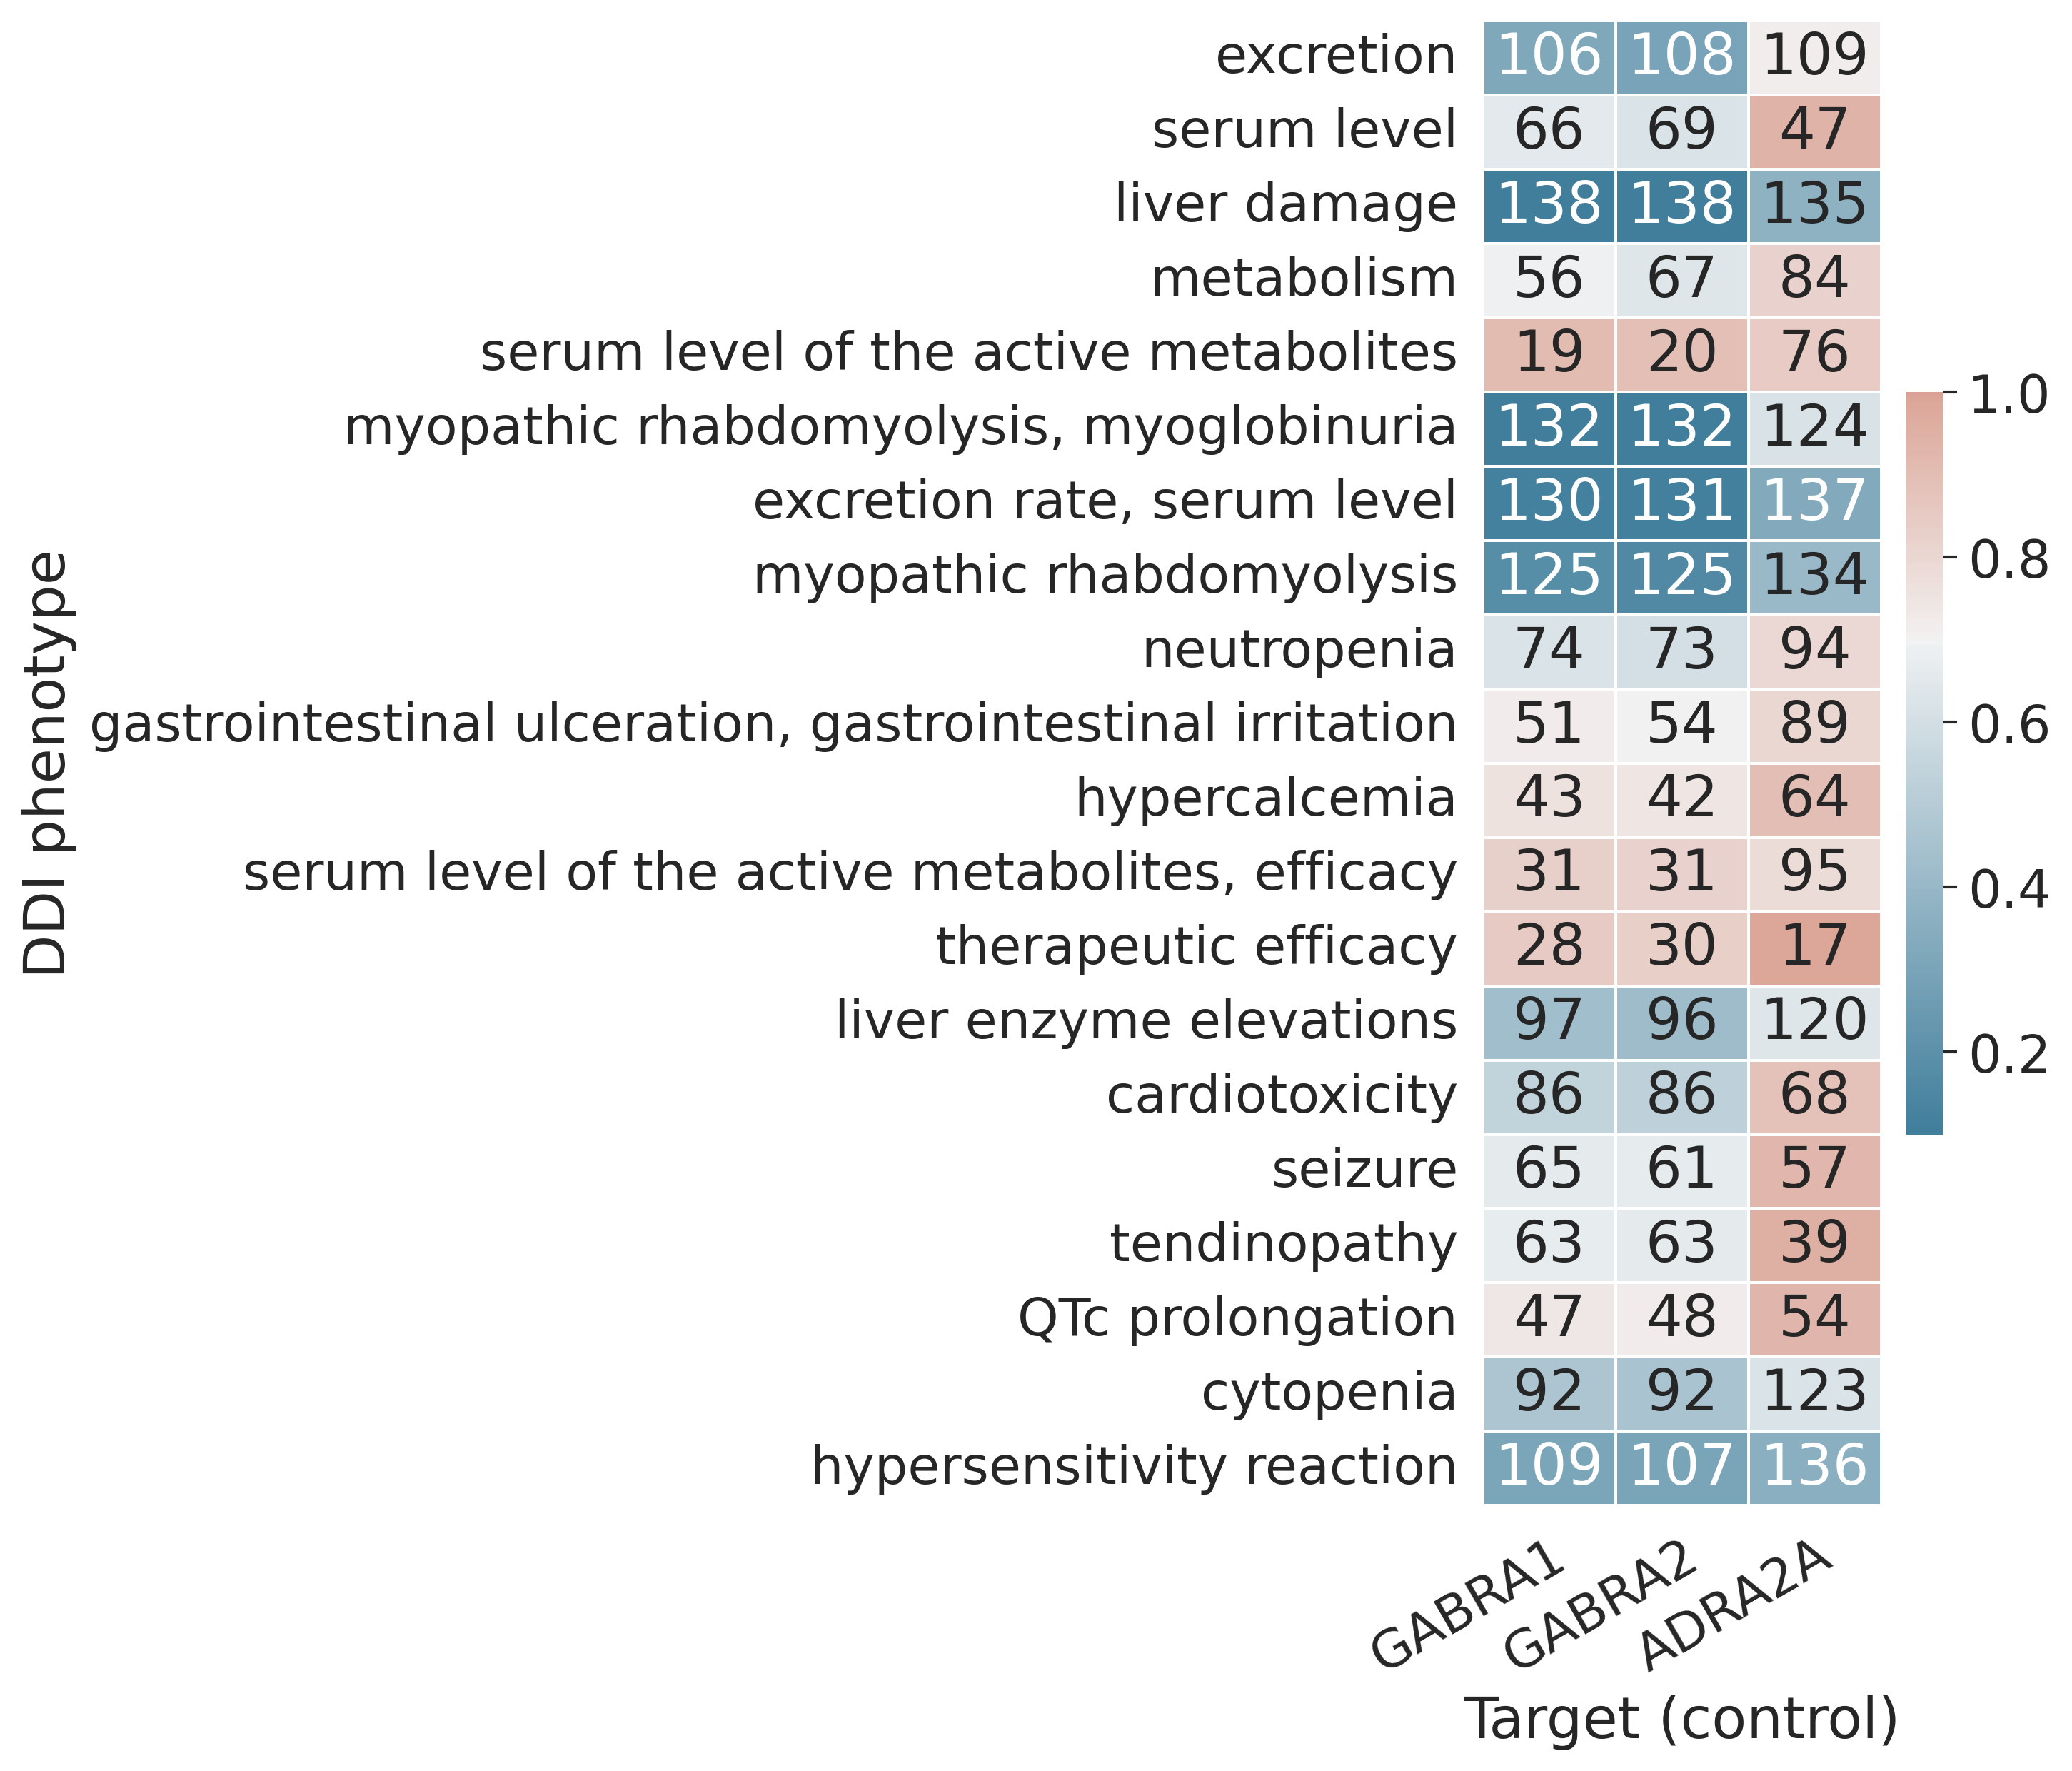

In [ ]:
f, ax = plt.subplots(figsize=(3, 9), dpi=300)
sns.set(context="paper", style="white", font_scale=2)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    all_target_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_target_ddi_scores_grouped_highest_ddi_phenos.columns if not col.endswith("_rank")]
    ], 
    annot=all_target_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_target_ddi_scores_grouped_highest_ddi_phenos.columns if col.endswith("_rank")]
    ].values, 
    fmt="d",
    cmap=cmap, 
    linewidths=.5,
    cbar_kws={"shrink": .5}, 
    ax=ax,
    center=.7, vmax=1.0, vmin=0.1
)

plt.ylabel("DDI phenotype")  # of\n{protein_type}-related DDI events
plt.xlabel("Target (control)")
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
# plt.title("")
plt.savefig("../figs/fig2_protein_mechanism_targets_mediated_ddi_targets_stratified_grouped.svg", format="svg", dpi=300)
plt.show()

Carrier

In [ ]:
carrier_uniprot_to_protein_name = {uniprot_id: uniprot_id_to_name[uniprot_id] for uniprot_id in drug_metadata_drugbank_with_proteins["carriers"].explode().value_counts()[:10].index}
print(carrier_uniprot_to_protein_name)
carrier_uniprot_to_protein_name = {
    uniprot_id: carrier_uniprot_to_protein_name[uniprot_id] 
    for uniprot_id in ["P02768", "P02763", "P19652"]
}

{'P02763': 'ORM1',
 'P02766': 'TTR',
 'P02768': 'ALB',
 'P02787': 'TF',
 'P04278': 'SHBG',
 'P05543': 'SERPINA7',
 'P08185': 'SERPINA6',
 'P12104': 'FABP2',
 'P15090': 'FABP4',
 'P19652': 'ORM2'}


In [118]:
all_carrier_ddi_scores_grouped_sorted_by_median = {}

for carrier in carrier_uniprot_to_protein_name.keys():
    drugs_with_carrier = drug_metadata_drugbank_with_proteins[drug_metadata_drugbank_with_proteins["carriers"].apply(lambda st: carrier in st)].index.values
    normalized_ranks_drugs_with_carrier = normalized_rank_drugbank[:, drugs_with_carrier, :][:, :, drugs_with_carrier]
    tril_indices = np.tril_indices(normalized_ranks_drugs_with_carrier.shape[1], k=-1)
    
    normalized_ranks_drugs_with_carrier_grouped = np.empty((
        organs_csv_neutralized_unique.shape[0], 
        normalized_ranks_drugs_with_carrier.shape[1],
        normalized_ranks_drugs_with_carrier.shape[2],
    ))

    for ind, ddi_class in enumerate(organs_csv_neutralized_unique["ddi_class"].values):
        normalized_ranks_drugs_with_carrier_grouped[ind, :, :] = normalized_ranks_drugs_with_carrier[organs_csv_neutralized["ddi_class"].values == ddi_class, :, :].max(axis=0)
    
    carrier_ddi_scores_grouped_sorted_by_median = np.median(normalized_ranks_drugs_with_carrier_grouped[:, tril_indices[0], tril_indices[1]], axis=1)
    temp = organs_csv_neutralized_unique.iloc[np.argsort(carrier_ddi_scores_grouped_sorted_by_median)[::-1]]
    temp["normalized_rank"] = np.sort(carrier_ddi_scores_grouped_sorted_by_median)[::-1]
    all_carrier_ddi_scores_grouped_sorted_by_median[carrier] = temp

/tmp/ipykernel_20193/2434167619.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(carrier_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/2434167619.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(carrier_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/2434167619.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [ ]:
all_carrier_ddi_scores_grouped_highest_ddi_phenos = {}

for carrier in carrier_uniprot_to_protein_name.keys():
    all_carrier_ddi_scores_grouped_highest_ddi_phenos[carrier] = \
    all_carrier_ddi_scores_grouped_sorted_by_median[carrier]["normalized_rank"].loc[highest_ddi_phenos]
    all_carrier_ddi_scores_grouped_highest_ddi_phenos[carrier+"_rank"] = \
    np.argsort(all_carrier_ddi_scores_grouped_sorted_by_median[carrier]["normalized_rank"].index.values)[highest_ddi_phenos] + 1

all_carrier_ddi_scores_grouped_highest_ddi_phenos = pd.DataFrame.from_dict(all_carrier_ddi_scores_grouped_highest_ddi_phenos)
all_carrier_ddi_scores_grouped_highest_ddi_phenos["ddi_index"] = highest_ddi_phenos
all_carrier_ddi_scores_grouped_highest_ddi_phenos["ddi_phenotype"] = organs_csv_neutralized_unique.loc[highest_ddi_phenos, "ddi_class"].values

all_carrier_ddi_scores_grouped_highest_ddi_phenos = (
    all_carrier_ddi_scores_grouped_highest_ddi_phenos.set_index("ddi_phenotype").
    loc[all_transporter_ddi_scores_grouped_highest_ddi_phenos.index].
    drop(columns=["ddi_index"])
)
all_carrier_ddi_scores_grouped_highest_ddi_phenos.columns = all_carrier_ddi_scores_grouped_highest_ddi_phenos.columns.map(lambda x: carrier_uniprot_to_protein_name[x] if x in carrier_uniprot_to_protein_name.keys() else x)

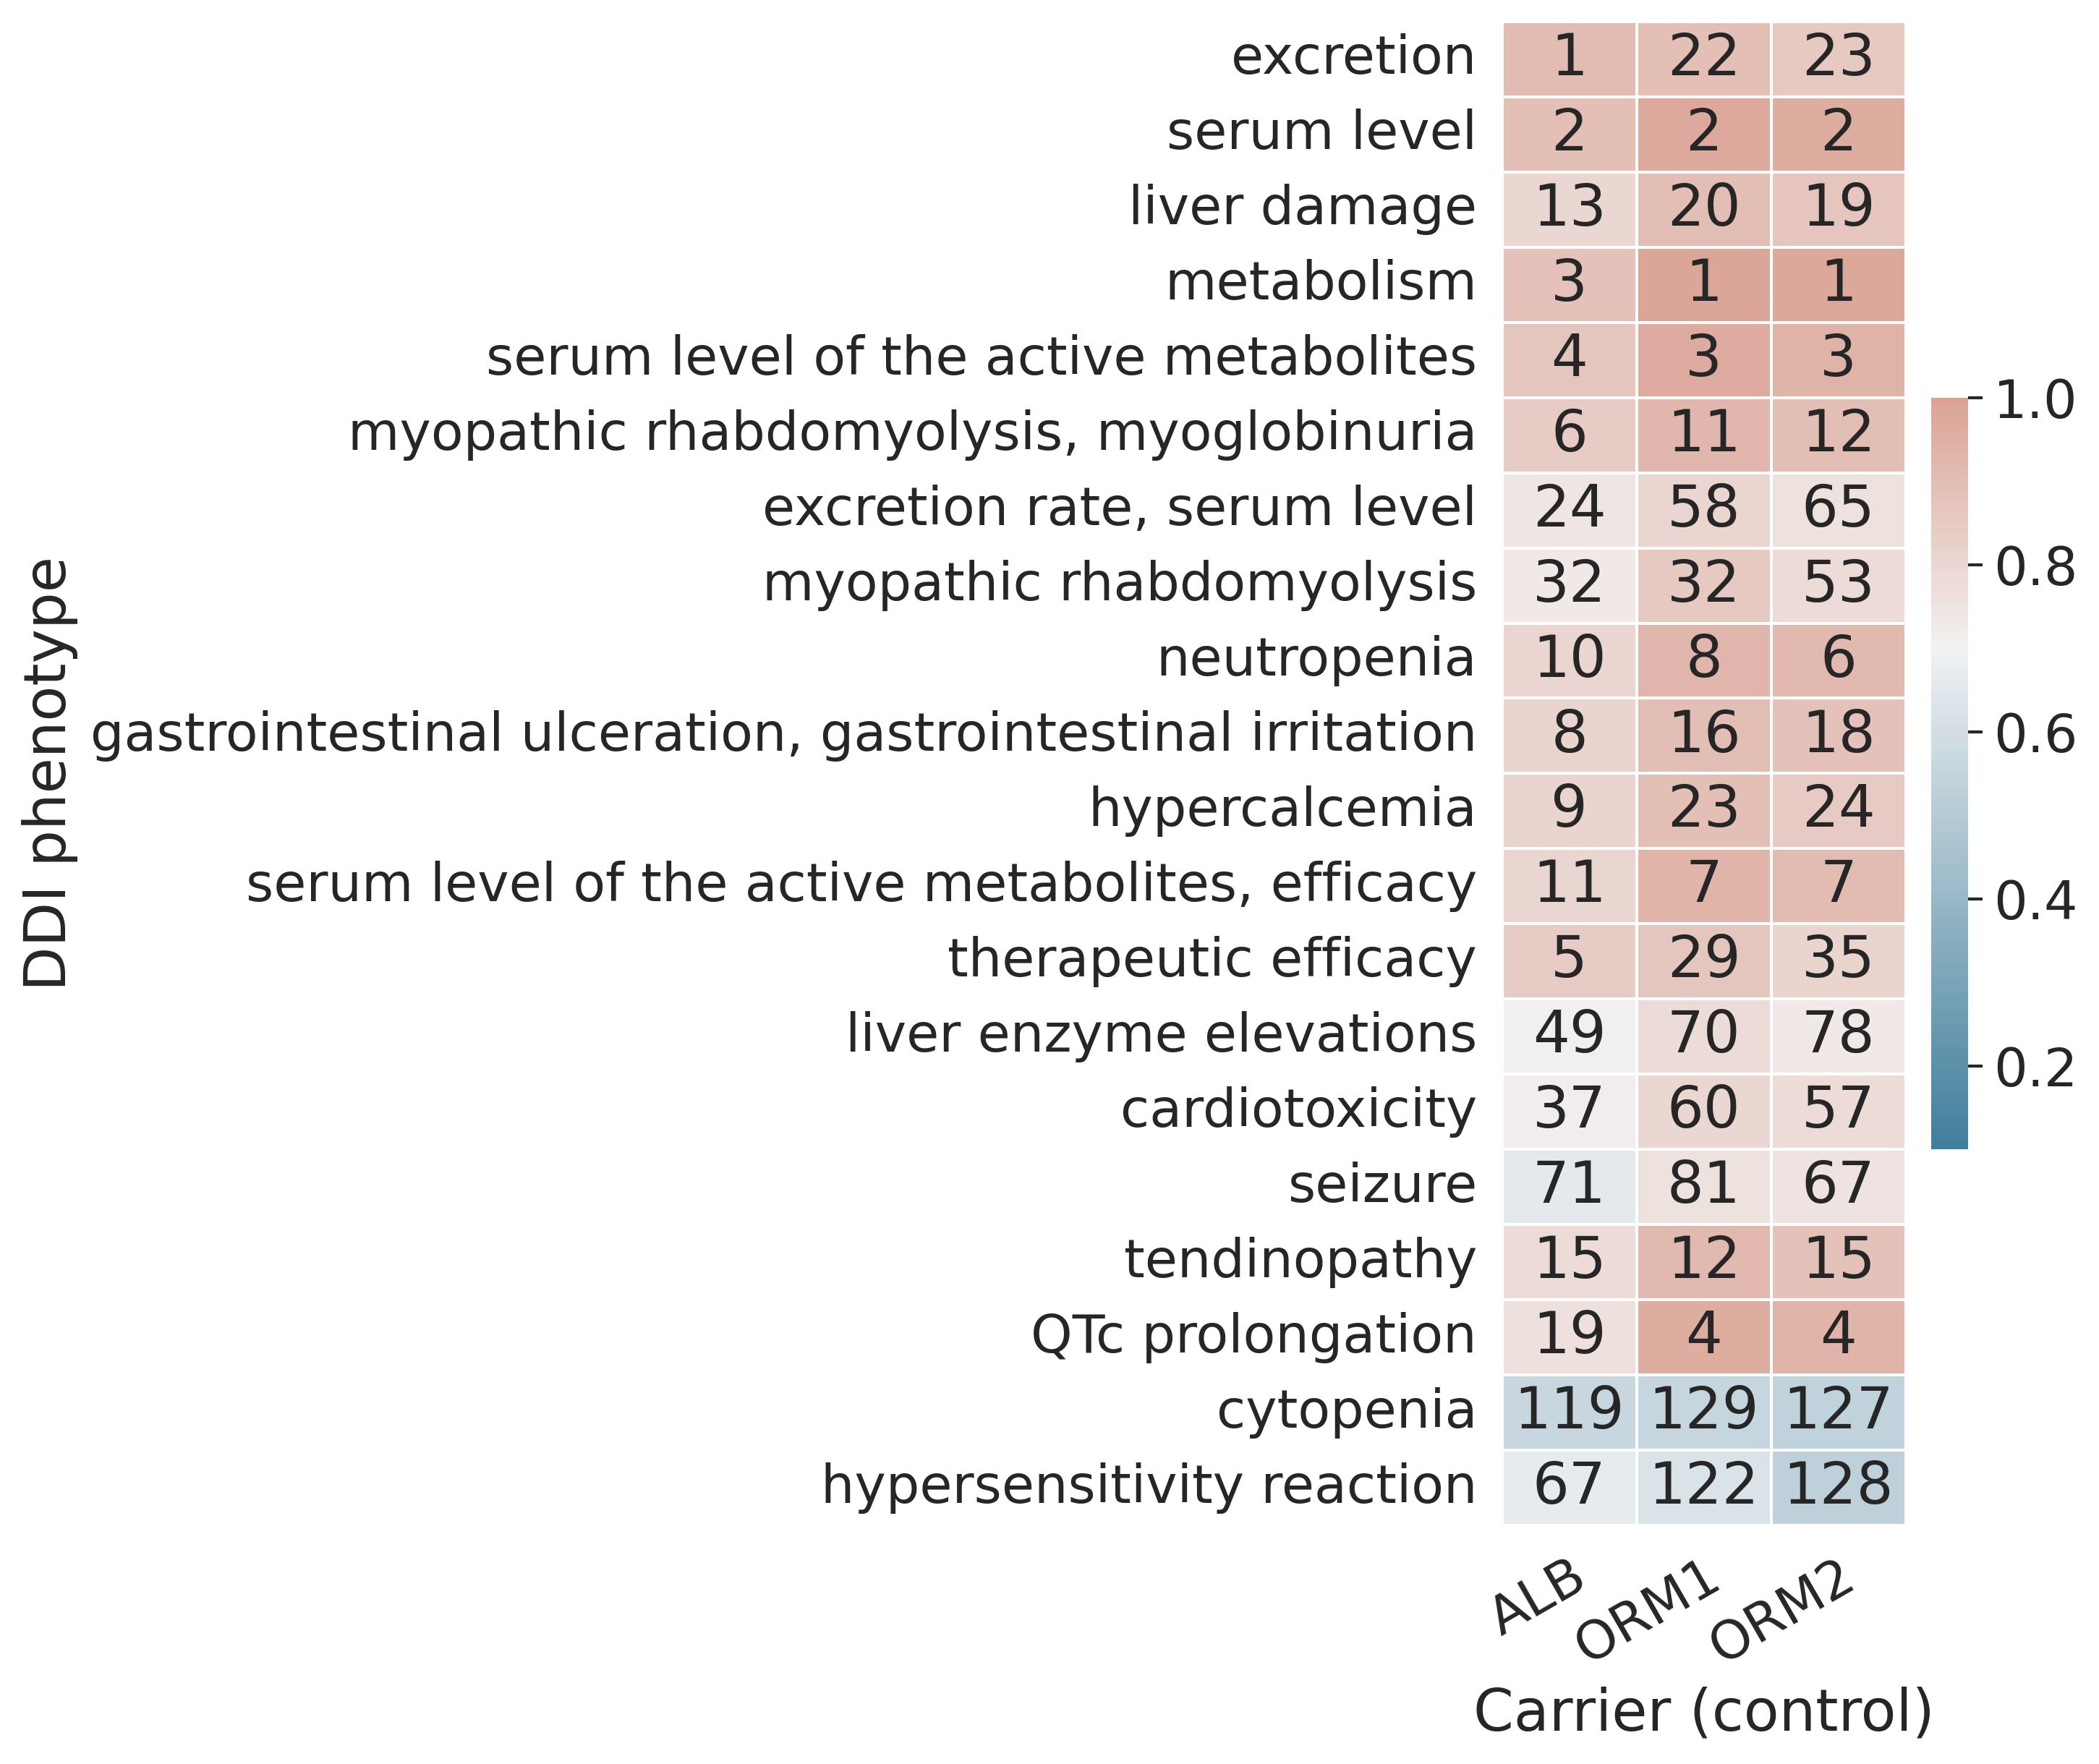

In [ ]:
f, ax = plt.subplots(figsize=(3, 9), dpi=300)
sns.set(context="paper", style="white", font_scale=2)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    all_carrier_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_carrier_ddi_scores_grouped_highest_ddi_phenos.columns if not col.endswith("_rank")]
    ], 
    annot=all_carrier_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_carrier_ddi_scores_grouped_highest_ddi_phenos.columns if col.endswith("_rank")]
    ].values, 
    fmt="d",
    cmap=cmap, 
    linewidths=.5,
    cbar_kws={"shrink": .5}, 
    ax=ax,
    center=.7, vmax=1.0, vmin=0.1
)

plt.ylabel("DDI phenotype")  # of\n{protein_type}-related DDI events
plt.xlabel("Carrier (control)")
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
# plt.title("")
plt.savefig("../figs/fig2_protein_mechanism_carriers_mediated_ddi_carriers_stratified_grouped.svg", format="svg", dpi=300)
plt.show()

Enzyme

In [ ]:
enzyme_uniprot_to_protein_name = {uniprot_id: uniprot_id_to_name[uniprot_id] for uniprot_id in drug_metadata_drugbank_with_proteins["enzymes"].explode().value_counts()[:20].index}
print(enzyme_uniprot_to_protein_name)
enzyme_uniprot_to_protein_name = {
    uniprot_id: enzyme_uniprot_to_protein_name[uniprot_id] 
    for uniprot_id in ["P08684", "P20815", "P22309", ]
}

{'O60656': 'UGT1A9',
 'P04798': 'CYP1A1',
 'P05177': 'CYP1A2',
 'P05181': 'CYP2E1',
 'P06276': 'BCHE',
 'P08684': 'CYP3A4',
 'P10632': 'CYP2C8',
 'P10635': 'CYP2D6',
 'P11509': 'CYP2A6',
 'P11511': 'CYP19A1',
 'P11712': 'CYP2C9',
 'P16662': 'UGT2B7',
 'P20813': 'CYP2B6',
 'P20815': 'CYP3A5',
 'P22309': 'UGT1A1',
 'P24462': 'CYP3A7',
 'P33261': 'CYP2C19',
 'P35503': 'UGT1A3',
 'Q16678': 'CYP1B1',
 'Q9HB55': 'CYP3A43'}


In [129]:
all_enzyme_ddi_scores_grouped_sorted_by_median = {}

for enzyme in enzyme_uniprot_to_protein_name.keys():
    drugs_with_enzyme = drug_metadata_drugbank_with_proteins[drug_metadata_drugbank_with_proteins["enzymes"].apply(lambda st: enzyme in st)].index.values
    normalized_ranks_drugs_with_enzyme = normalized_rank_drugbank[:, drugs_with_enzyme, :][:, :, drugs_with_enzyme]
    tril_indices = np.tril_indices(normalized_ranks_drugs_with_enzyme.shape[1], k=-1)
    
    normalized_ranks_drugs_with_enzyme_grouped = np.empty((
        organs_csv_neutralized_unique.shape[0], 
        normalized_ranks_drugs_with_enzyme.shape[1],
        normalized_ranks_drugs_with_enzyme.shape[2],
    ))

    for ind, ddi_class in enumerate(organs_csv_neutralized_unique["ddi_class"].values):
        normalized_ranks_drugs_with_enzyme_grouped[ind, :, :] = normalized_ranks_drugs_with_enzyme[organs_csv_neutralized["ddi_class"].values == ddi_class, :, :].max(axis=0)
    
    enzyme_ddi_scores_grouped_sorted_by_median = np.median(normalized_ranks_drugs_with_enzyme_grouped[:, tril_indices[0], tril_indices[1]], axis=1)
    temp = organs_csv_neutralized_unique.iloc[np.argsort(enzyme_ddi_scores_grouped_sorted_by_median)[::-1]]
    temp["normalized_rank"] = np.sort(enzyme_ddi_scores_grouped_sorted_by_median)[::-1]
    all_enzyme_ddi_scores_grouped_sorted_by_median[enzyme] = temp

/tmp/ipykernel_20193/1921218445.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(enzyme_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/1921218445.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["normalized_rank"] = np.sort(enzyme_ddi_scores_grouped_sorted_by_median)[::-1]
/tmp/ipykernel_20193/1921218445.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
all_enzyme_ddi_scores_grouped_highest_ddi_phenos = {}

for enzyme in enzyme_uniprot_to_protein_name.keys():
    all_enzyme_ddi_scores_grouped_highest_ddi_phenos[enzyme] = \
    all_enzyme_ddi_scores_grouped_sorted_by_median[enzyme]["normalized_rank"].loc[highest_ddi_phenos]
    all_enzyme_ddi_scores_grouped_highest_ddi_phenos[enzyme+"_rank"] = \
    np.argsort(all_enzyme_ddi_scores_grouped_sorted_by_median[enzyme]["normalized_rank"].index.values)[highest_ddi_phenos] + 1

all_enzyme_ddi_scores_grouped_highest_ddi_phenos = pd.DataFrame.from_dict(all_enzyme_ddi_scores_grouped_highest_ddi_phenos)
all_enzyme_ddi_scores_grouped_highest_ddi_phenos["ddi_index"] = highest_ddi_phenos
all_enzyme_ddi_scores_grouped_highest_ddi_phenos["ddi_phenotype"] = organs_csv_neutralized_unique.loc[highest_ddi_phenos, "ddi_class"].values

all_enzyme_ddi_scores_grouped_highest_ddi_phenos = (
    all_enzyme_ddi_scores_grouped_highest_ddi_phenos.set_index("ddi_phenotype").
    loc[all_transporter_ddi_scores_grouped_highest_ddi_phenos.index].
    drop(columns=["ddi_index"])
)
all_enzyme_ddi_scores_grouped_highest_ddi_phenos.columns = all_enzyme_ddi_scores_grouped_highest_ddi_phenos.columns.map(lambda x: enzyme_uniprot_to_protein_name[x] if x in enzyme_uniprot_to_protein_name.keys() else x)

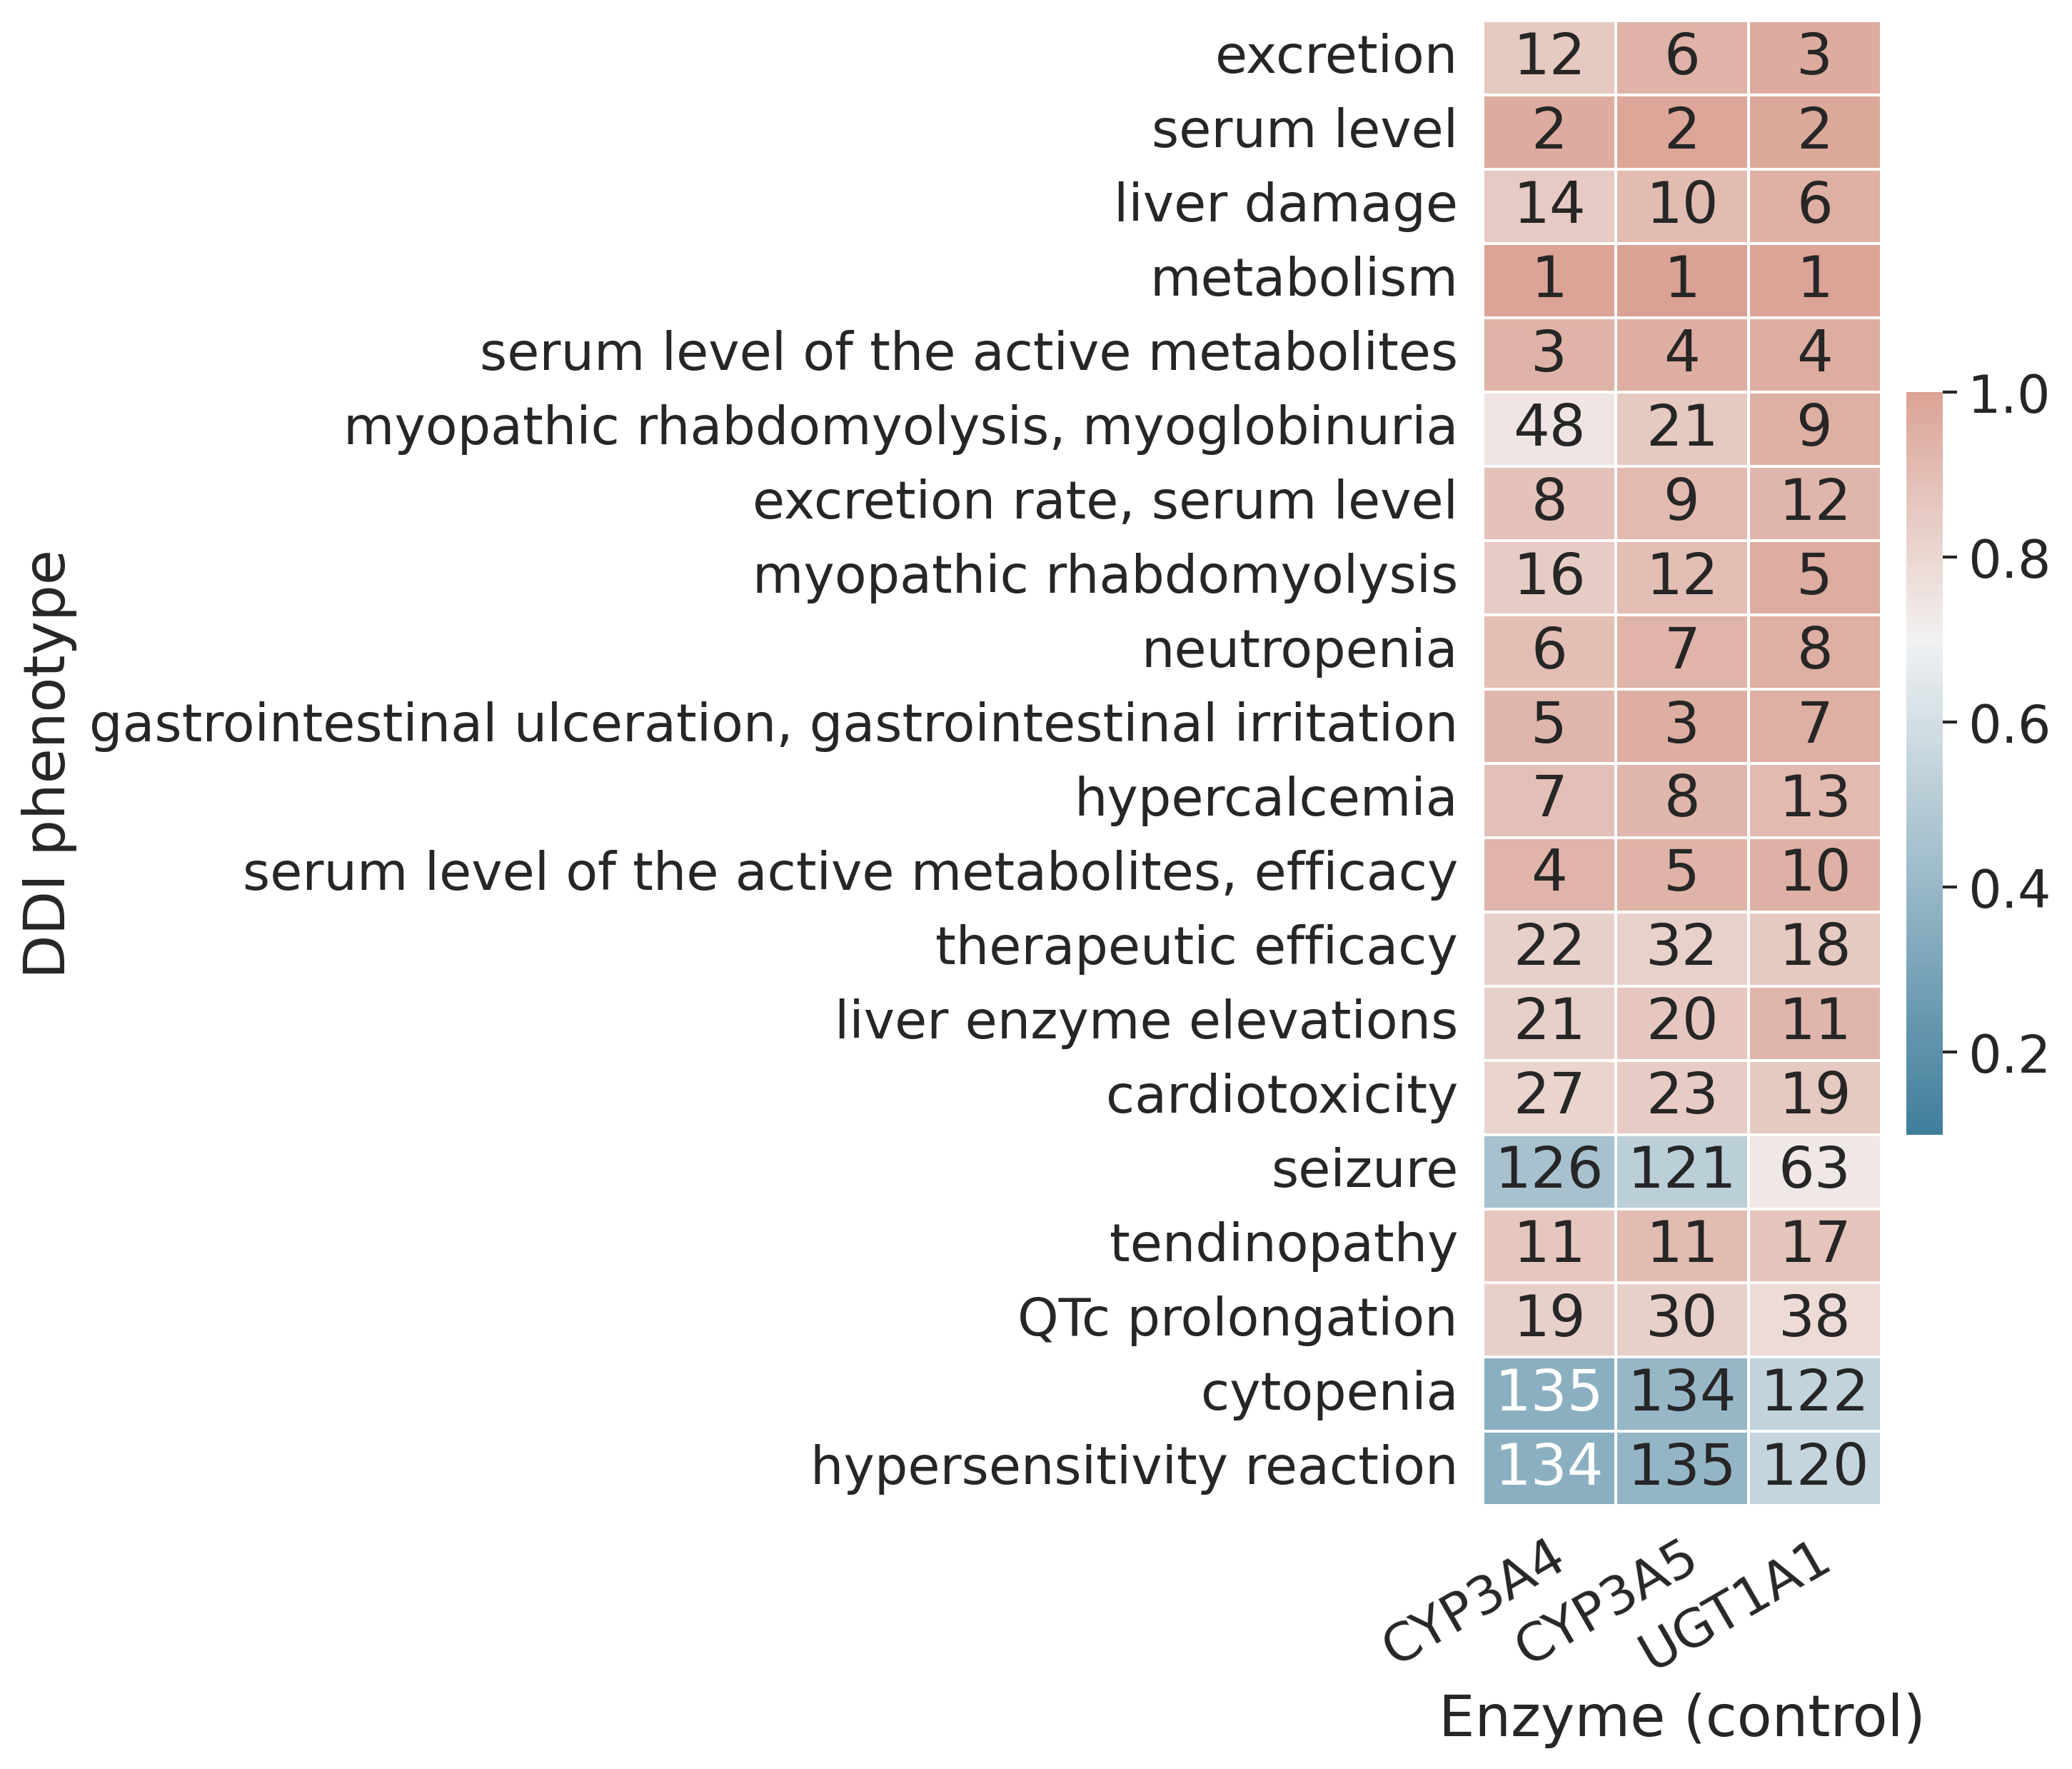

In [ ]:
f, ax = plt.subplots(figsize=(3, 9), dpi=300)
sns.set(context="paper", style="white", font_scale=2)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    all_enzyme_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_enzyme_ddi_scores_grouped_highest_ddi_phenos.columns if not col.endswith("_rank")]
    ], 
    annot=all_enzyme_ddi_scores_grouped_highest_ddi_phenos[
        [col for col in all_enzyme_ddi_scores_grouped_highest_ddi_phenos.columns if col.endswith("_rank")]
    ].values, 
    fmt="d",
    cmap=cmap, 
    linewidths=.5,
    cbar_kws={"shrink": .5}, 
    ax=ax,
    center=.7, vmax=1.0, vmin=0.1
)

plt.ylabel("DDI phenotype")  # of\n{protein_type}-related DDI events
plt.xlabel("Enzyme (control)")
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
# plt.title("")
plt.savefig("../figs/fig2_protein_mechanism_enzymes_mediated_ddi_enzymes_stratified_grouped.svg", format="svg", dpi=300)
plt.show()